# Titanic 

## Project Description

### Overview
---
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Description of  features within dataset 
---
| Variable | Definition | Key |
|---|---|---|
|survival | Survival | 0 = No, 1 = Yes
|pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd
|sex	| Sex |
|Age	| Age in years |	
|sibsp	| # of siblings / spouses aboard the Titanic |	
|parch	| # of parents / children aboard the Titanic |	
|ticket	| Ticket number	|
|fare	| Passenger fare |	
|cabin	| Cabin number |	
|embarked |	Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

### Variable Notes
---
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


## Data exploration

In [1]:
## Import dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sys
import os
os.getcwd()
sys.path.insert(0, '..')
from src.correlation_eval import theils_u

In [296]:
## load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
full_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

### General Information

#### Observations:
- the training set contains 891 samples,while the testing set contains  418 samples
- For the training set, Column Age, Cabin, Embarked have missing values
- For the testing set, Age, Fare and Cabin have missing values

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Missing values

(add insights)

In [9]:
train_count_nan=train_data.isna().sum(axis=0)
test_count_nan=test_data.isna().sum(axis=0)
train_count_nan[train_count_nan>0]


Age         177
Cabin       687
Embarked      2
dtype: int64

Missing values in the test set: Age, Fare, Cabin

In [10]:
test_count_nan[test_count_nan>0]

Age       86
Fare       1
Cabin    327
dtype: int64

### Assumptions:

#### Direct information
- Pclass: Higher (1st) class passengers could have higher survive possibility
- Name: From the name infomation we could extract their title which could be related with survive chance
- Sex: Female may has higher survive possibility
- Age: Older people may have lower survive possibility, child is most likely survived?
- sibsp, parch: person with more relatives may have higher survive possibility?
- Fare: Fare is related with Pclass, person have higher fare may has higher surivie possibility
- Embarked: the place of embarked may affect the survive possibility

#### Passenger groups
- Passeger can be grouped according with their profile, such as travelling as family, etc.

##### Pclass & Sex

- Observations:
    1. Person in higher cabin class is most likely to survive.
    2. Female is most likely to survive.
- Decisions:
    1. Both Pclass and Sex will be used as categorical features for the model.


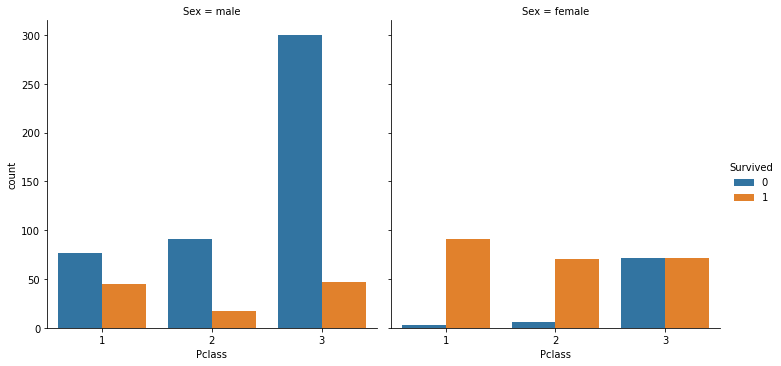

In [34]:
g=sns.catplot(data=train_data, x='Pclass', col='Sex', hue='Survived', kind='count')

##### Age

Please note there are a fraction of missing data for age, those data shall be added by some methods later

- Observations:
    1. Infant has a much higher survive possibility
    2. the oldest person(Age=80) survived which shall be removed as an outlier
    3. most passengers' age are in bewteen 15 and 40
    4. higher fraction of passengers are in Pclass 1
- Decisions:
    1. consider to bucktize the data or use it in a continuous form directly
    2. consider to remove the person who is aged at 80 for model trainning
    3. For the missing value, it has been found the age is related with the title in the name and number of relatives, a KNNimputer will be used to fill those data

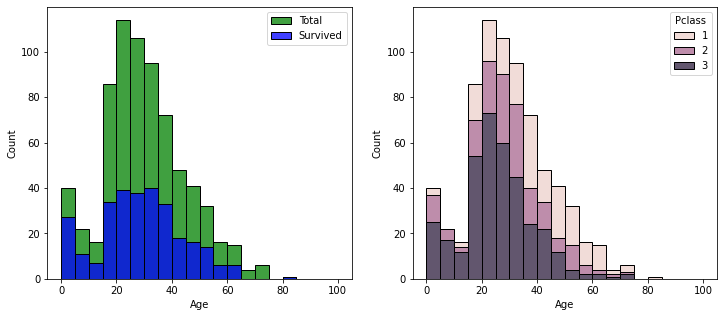

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

g1 = sns.histplot(data=train_data, x='Age', ax=ax[0], color='g', bins=20, binrange=(0, 100))
g2 = sns.histplot(data=train_data[train_data['Survived']==1]
                  , x='Age', ax=ax[0], color='b', bins=20, binrange=(0, 100))
ax[0].legend(labels=['Total', 'Survived'])

g1 = sns.histplot(data=train_data, x='Age', ax=ax[1], 
                  multiple='stack', hue='Pclass',
                  bins=20, binrange=(0, 100))

Text(0, 0.5, 'survive fraction')

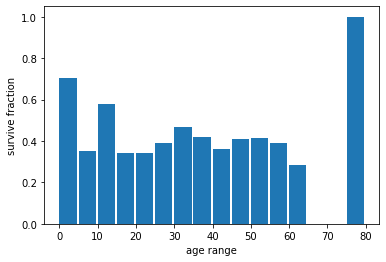

In [107]:
bins = [i for i in range(0, 85, 5)]
train_data['Age_binned'] = pd.cut(train_data['Age'], bins=bins)
fig, ax = plt.subplots(1,1)
fraction = (train_data[['Survived', 'Age_binned']]
            .groupby('Age_binned', as_index=False)
            .mean()['Survived'])
fraction
ax.bar(x=bins[:-1], height=fraction, align='edge', width=4.5)
ax.set_xlabel('age range')
ax.set_ylabel('survive fraction')

##### SibSp & Parch
Please aware that the number of relatives of person onboard could also be related with his/her age

- Observations:
    1. The relationship between SibSp&Parch with surviving possibility is not clear
- Decisions:
    1. we shell derive some new feature use it or discard it
    

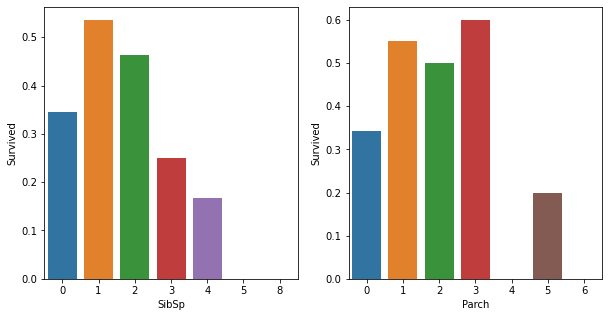

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_1 = (train_data[['SibSp', 'Survived']]
        .groupby('SibSp', as_index=False)
        .mean().sort_values(by='SibSp'))
df_2 = (train_data[['Parch', 'Survived']]
        .groupby('Parch', as_index=False)
        .mean().sort_values(by='Parch'))
ax1 = sns.barplot(data=df_1, x='SibSp', y='Survived',  ax=ax[0])
ax2 = sns.barplot(data=df_2, x='Parch', y='Survived',  ax=ax[1])


- No direct information about Surviving chance can be obtained directly from SibSp and Parch

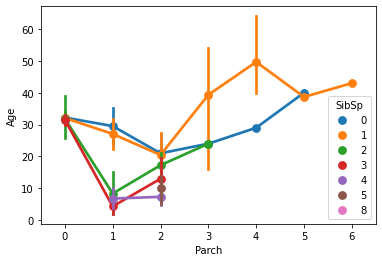

In [38]:
g = sns.pointplot(data=train_data, hue='SibSp', x='Parch', y='Age')

##### Name
- From name we can obtain the title infomation
- it can be found the people with different title can show some correlation with surviving result

In [302]:
for dataset in (train_data, test_data):
    dataset['Title'] = dataset['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    dataset['Title_cat']=dataset['Title'].apply(
        lambda x: x if x in {'Mr', 'Miss', 'Mrs', 'Master'} else 'others'
    )

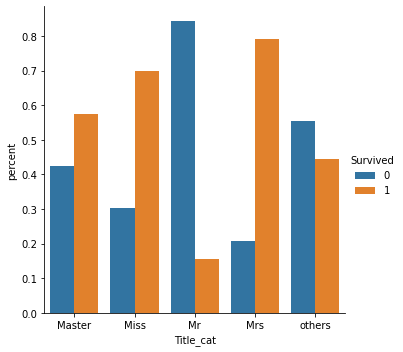

In [305]:
df = train_data.groupby(['Title_cat'])['Survived'].value_counts(normalize=True)
df = df.rename('percent').reset_index()
g = sns.catplot(kind='bar', data=df, x='Title_cat', y='percent', hue='Survived')

##### Fare

- Observations:
    1. Passeger paid higher fare is likely to survive

- Decisions:
    2. consider to use it as continuous feature directly or binned in the model

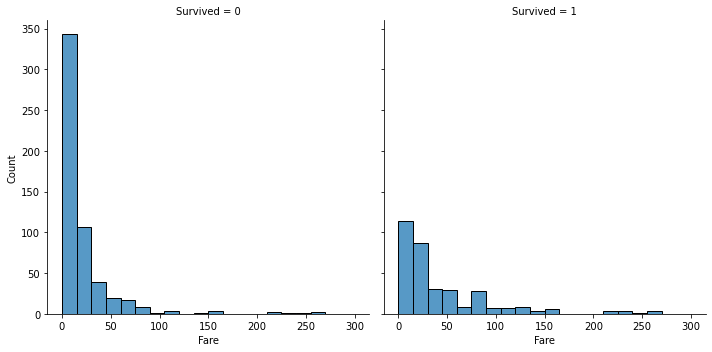

In [141]:
g = sns.displot(data=train_data, col='Survived', x='Fare', bins=20, binrange=(0, 300))

##### Embarked

- Observations:
    1. Passegers embarked at S has a lower survive possibility for all three Pclass

- Decisions:
    2. Embarked will be used as a categorical feature in the model



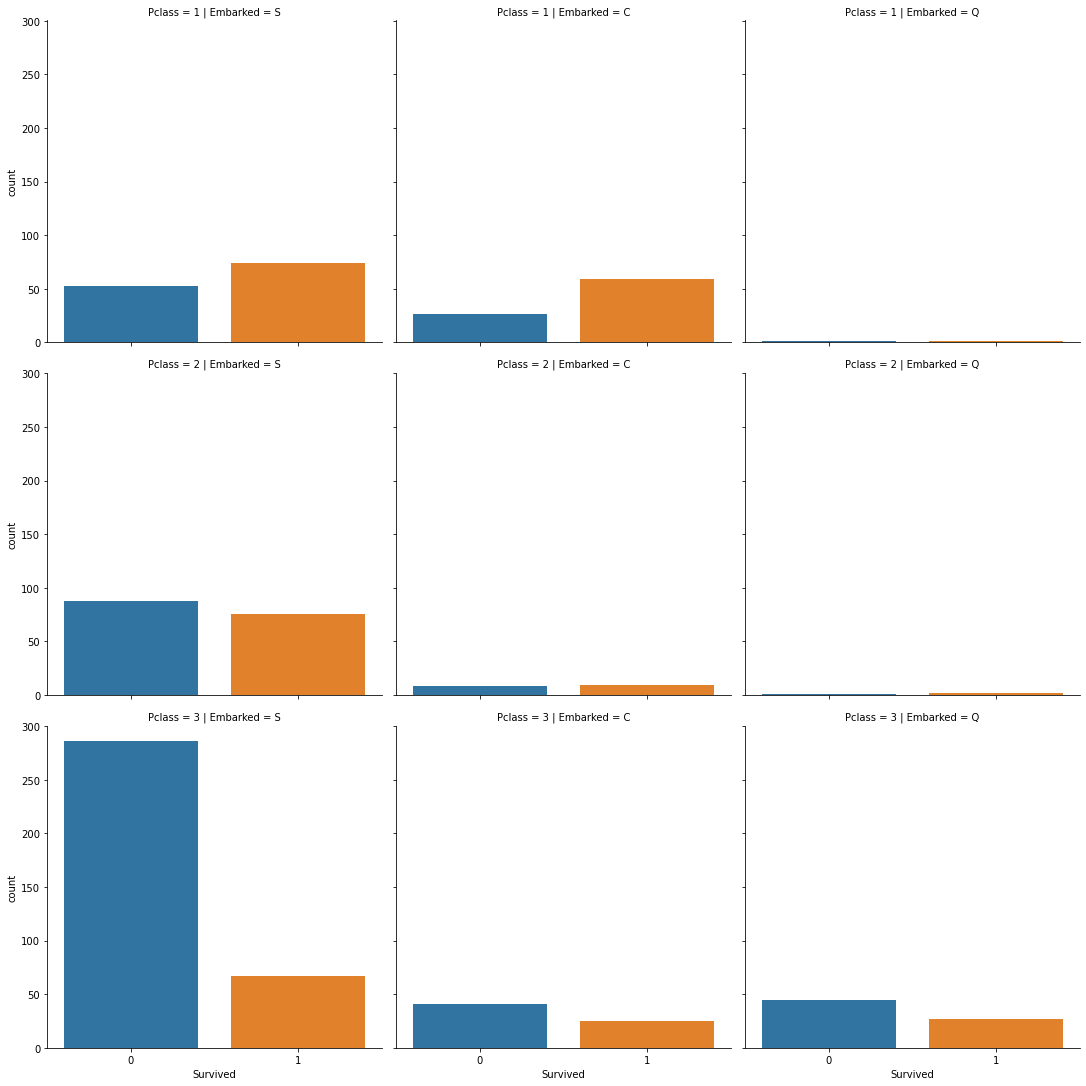

In [155]:
g=sns.catplot(data=train_data, col='Embarked', row='Pclass', x='Survived', kind='count')

## Explore family group infomation

### Potential features 
- YoungWithGroup(<18) 0: Not Young 1: Young Alone, 2: Young with sib/par
- MaleWithGroup(>18) 0: Male with SP/Young, 1: Male alone 2: Not Male(>18)
- FemaleWithGroup(>18) 0: Not Female(>18), 1:Female alone 2: Female with SP/Male
- FamilySurvive 0: Family perished, 1: Alone, 2: Family Survived

In [306]:
full_data = pd.concat([train_data, test_data], ignore_index=True)
len_train, len_test = train_data.shape[0], test_data.shape[0]
full_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Title_cat'],
      dtype='object')

In [307]:
full_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [308]:
## Extract last Name

full_data['Lastname']=full_data['Name'].apply(lambda x: x.split(',')[0])

In [309]:
## Extract Titles
title_map={'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
           'Don': 'Mr', 'Rev': 'Mr', 'Mme': 'Miss', 'Ms': 'Miss', 'Major':'Mr',
           'Lady': 'Mrs', 'Sir': 'Mr', 'Mlle': 'Miss', 'Col': 'Mr', 'Capt':'Mr',
           'Countess': 'Mrs', 'Jonkheer': 'Mr', 'Dona': 'Mrs', 'Dr': 'Mr'
          }
full_data['Title'] = full_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
full_data['Title'] = full_data['Title'].apply(lambda x: title_map[x])

#### Add FamilySurvived Feature

In [311]:
DEFUALT_FAMILYSURVIVE=1
full_data['FamilySurvived'] = DEFUALT_FAMILYSURVIVE
for grp, grp_df in full_data.groupby(['Lastname', 'Fare']):
    if grp_df.shape[0]>1:
        for idx, row in grp_df.iterrows():
            s_max = grp_df.drop(idx)['Survived'].max()
            s_min = grp_df.drop(idx)['Survived'].min()
            if s_max == 1:
                full_data.loc[idx ,'FamilySurvived'] = 2
            elif s_min == 0:
                full_data.loc[idx ,'FamilySurvived'] = 0

for grp, grp_df in full_data.groupby(['Ticket']):
    if grp_df.shape[0]>1:
        for idx, row in grp_df.iterrows():
            present_cond= (row['FamilySurvived']==0) | (row['FamilySurvived']==1)
            family_cond = (row['SibSp']!=0) | (row['Parch']!=0)
            if present_cond & family_cond:
                
                s_max = grp_df.drop(idx)['Survived'].max()
                s_min = grp_df.drop(idx)['Survived'].min()
                if s_max == 1:
                    full_data.loc[idx ,'FamilySurvived'] = 2
                elif s_min == 0:
                    full_data.loc[idx ,'FamilySurvived'] = 0   

In [312]:
full_data.loc[full_data['FamilySurvived']!=1, 'Pclass'].count()

447

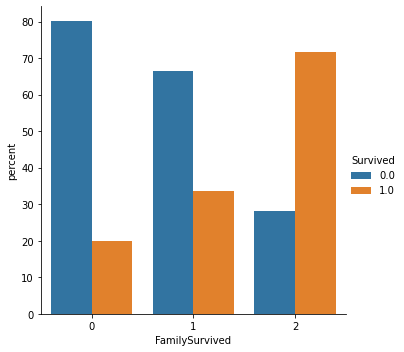

In [313]:
df1 = full_data[:len_train].groupby(['FamilySurvived'])['Survived'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
p = sns.catplot(data=df1, x='FamilySurvived', y='percent',
                hue='Survived', kind='bar',  )


#### Add YoungWithGroup Feature
YoungWithGroup(<18)  0: Not Young 1: Young Alone, 2: Young with sib/par

In [314]:
DEFAULT_YOUNGWITHGROUP = 0
full_data['YoungWithGroup'] = DEFAULT_YOUNGWITHGROUP
for grp, grp_df in full_data.groupby(['Lastname', 'Fare']):
    if grp_df.shape[0]==1:
        for idx, row in grp_df.iterrows():
            if (row['Age'] <= 18) | (row['Title']=='Master'):
                full_data.loc[idx, 'YoungWithGroup'] = 1
    
    elif grp_df.shape[0]>1:
        for idx, row in grp_df.iterrows():
            age_cond = row['Age'] <= 18
            title_cond = row['Title'] == 'Master'  # for boys
            if age_cond | title_cond :
                if grp_df['Age'].max() > 20: 
                    full_data.loc[idx, 'YoungWithGroup'] = 2
                else : full_data.loc[idx, 'YoungWithGroup'] = 2
                    
for grp, grp_df in full_data.groupby(['Ticket']):
    if grp_df.shape[0]>1:
        for idx, row in grp_df.iterrows():
            if row['YoungWithGroup'] == 1:
                if (row['Parch'] > 0) | (grp_df['Age'].max()>30):
                    full_data.loc[idx, 'YoungWithGroup'] = 2
                else:
                    full_data.loc[idx, 'YoungWithGroup'] = 1
                    


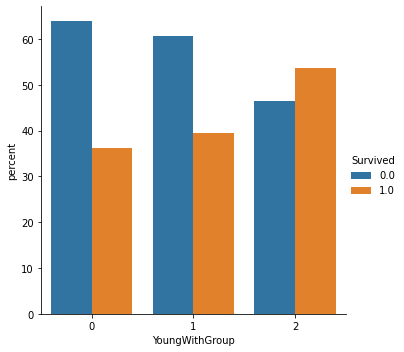

In [315]:
df1 = full_data[:len_train].groupby(['YoungWithGroup'])['Survived'].value_counts(normalize=True)
df1= df1.mul(100)
df1 = df1.rename('percent').reset_index()
p = sns.catplot(kind='bar', data=df1, x='YoungWithGroup', y='percent', hue='Survived')



#### Add MaleWithGroup(>18) Feature
MaleWithGroup(>18) 0: Male with SP/Young, 1: Male alone/ with male friends 2: Not Male(>18)

In [316]:
DEFAULT_MALEWITHGROUP = 2
full_data['MaleWithGroup'] = DEFAULT_MALEWITHGROUP

for grp, grp_df in full_data.groupby(['Ticket']):
    if grp_df.shape[0] == 1:
        for idx, row in grp_df.iterrows():
            if (row['Sex']=='male') & (row['Age']>18 or row['Age']==np.nan) & (row['Title']!='Master'):
                full_data.loc[idx, 'MaleWithGroup'] = 1
    else:
        for idx, row in grp_df.iterrows():
            if (row['Sex']=='male') & (row['Age']>18 or row['Age']==np.nan) & (row['Title']!='Master'):
                if (grp_df['Age'].min()<18) or 'Master' in grp_df['Title'].unique() or (
                ('female' in grp_df['Sex']) and row['Parch']==0):
                    full_data.loc[idx, 'MaleWithGroup'] = 0
                else:
                    full_data.loc[idx, 'MaleWithGroup'] = 1

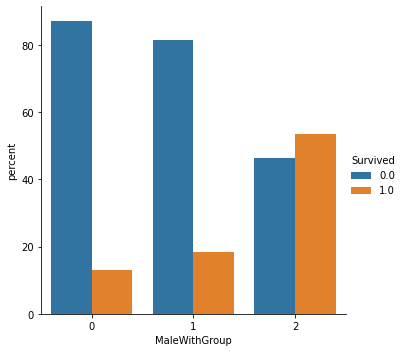

In [317]:
df1 = full_data[:len_train].groupby(['MaleWithGroup'])['Survived'].value_counts(normalize=True)
df1= df1.mul(100)
df1 = df1.rename('percent').reset_index()
p = sns.catplot(kind='bar', data=df1, x='MaleWithGroup', y='percent', hue='Survived')

#### Add FemaleWithGroup Feature
FemaleWithGroup(>18) 0: Not Female(>18), 1:Female alone 2: Female with SP/Male

In [318]:
DEFAULT_FEMALEWITHGROUP=0
full_data['FemaleWithGroup']=DEFAULT_FEMALEWITHGROUP

for grp, grp_df in full_data.groupby(['Ticket']):
    if grp_df.shape[0] == 1:
        for idx, row in grp_df.iterrows():
            if ((row['Sex'] == 'female') & (row['Age']>18)) or row['Title']=='Mrs' :
                full_data.loc[idx, 'FemaleWithGroup'] = 1
    else:
        for idx, row in grp_df.iterrows():
            if ((row['Sex'] == 'female') & (row['Age']>18)) or row['Title']=='Mrs':
                if ('Mr' in grp_df['Title'].unique()) & (grp_df.drop(idx)['Age'].max()>18):
                    full_data.loc[idx, 'FemaleWithGroup'] = 2
                else: full_data.loc[idx, 'FemaleWithGroup'] = 1
                

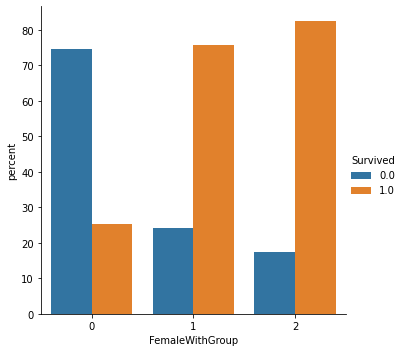

In [319]:
df1 = full_data[:len_train].groupby(['FemaleWithGroup'])['Survived'].value_counts(normalize=True)
df1= df1.mul(100)
df1 = df1.rename('percent').reset_index()
p = sns.catplot(kind='bar', data=df1, x='FemaleWithGroup', y='percent', hue='Survived')

#### Add IsAlone Feature

In [320]:
DEFAULT_ISALONE = 1
full_data['IsAlone'] = DEFAULT_ISALONE
full_data['IsAlone'] = full_data[['SibSp','Parch']].apply(
    lambda x: 0 if x[0]+x[1]>0 else 1, axis=1
)

## Build sklearn pipeline

In [353]:
input_full_data = full_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
                             'SibSp', 'Parch', 'MaleWithGroup', 'FemaleWithGroup',
                             'YoungWithGroup', 'IsAlone', 'FamilySurvived']].copy()
# , 'MaleWithGroup', 'FemaleWithGroup', 'FamilySurvived'
y_train = train_data['Survived'].values
title_encodes = {'Mr': 0, 'Mrs': 1, 'Miss':2, 'Master':3}
input_full_data['Title']=input_full_data['Title'].apply(lambda x: title_encodes[x])

In [322]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
cat_features = ['Title', 'Embarked', 'Sex']
age_features = ['Age', 'SibSp', 'Parch', 'Title']
fare_feature = ['Fare']
from sklearn.ensemble import RandomForestClassifier


In [323]:
from typing import List
from sklearn.base import BaseEstimator, TransformerMixin
class ArraySelector(BaseEstimator, TransformerMixin):
    '''
    # select sepecific feature columns from  np.array
    '''

    def __init__(self, col_idx: List[int]):
        self.col_idx = col_idx

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, self.col_idx]

    def get_feature_names_out(self, input_features=None):
        out_features = []
        for i in self.col_idx:
            out_features.append(input_features[i])
        return out_features

In [354]:
pipe_cat = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ]
)
pipe_age = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=15)),
        ('selector', ArraySelector(col_idx=[0])),
        ('bucket', KBinsDiscretizer(n_bins=5, strategy='uniform', encode='ordinal'))
    ]
)
pipe_fare = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('bucket', KBinsDiscretizer(n_bins=5, strategy='uniform', encode='ordinal'))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', pipe_cat, cat_features),
        ('age', pipe_age, age_features),
        ('fare', pipe_fare, fare_feature)
    ], remainder='passthrough'
)
model = RandomForestClassifier()
preprocess.fit(input_full_data)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['Title', 'Embarked', 'Sex']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=15)),
                                                 ('selector',
                                                  ArraySelector(col_idx=[0])),
                                                 ('bucket',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'))]),
                                 ['Age', 'SibSp', 'Parch', 'Title']),
                                ('fare',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('bucket',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'))]),
                                 ['Fare'])])

In [355]:
preprocess.get_feature_names_out()

array(['cat__Title', 'cat__Embarked', 'cat__Sex', 'age__Age',
       'fare__Fare', 'remainder__Pclass', 'remainder__MaleWithGroup',
       'remainder__FemaleWithGroup', 'remainder__YoungWithGroup',
       'remainder__IsAlone', 'remainder__FamilySurvived'], dtype=object)

In [359]:
X_train = preprocess.transform(input_full_data[:len_train])
X_test = preprocess.transform(input_full_data[len_train:])
y_train = train_data['Survived'].values
print(cross_val_score(model, X_train, y_train))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
submission_df = pd.DataFrame(
    {
        'PassengerId': test_data['PassengerId'],
        'Survived': y_pred
    }
)
submission_df.to_csv('submission_new.csv', index=False)

[0.81005587 0.81460674 0.84831461 0.81460674 0.85955056]


## Correlation heatmap

In [346]:
train_array = np.c_[X_train, y_train]
train_array.shape
columns = list(preprocess.get_feature_names_out())
columns = columns +['Survived']
t_df = pd.DataFrame(train_array, columns=columns)

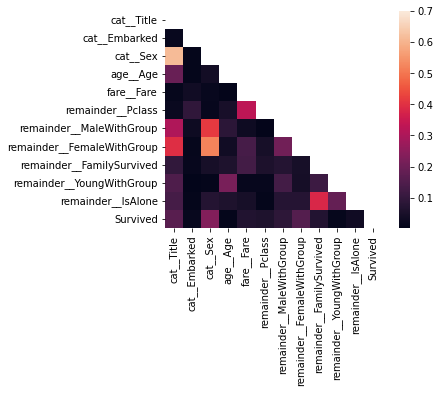

In [364]:
corr = t_df.corr(method=theils_u)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(corr, mask=mask, vmax=.7, square=True)

In [363]:
corr

,cat__Title,cat__Embarked,cat__Sex,age__Age,fare__Fare,remainder__Pclass,remainder__MaleWithGroup,remainder__FemaleWithGroup,remainder__FamilySurvived,remainder__YoungWithGroup,remainder__IsAlone,Survived
cat__Title,1.000000,0.018742,0.611018,0.189047,0.013683,0.020125,0.304566,0.393896,0.094337,0.146841,0.129778,0.161269
cat__Embarked,0.018742,1.000000,0.009356,0.009083,0.033983,0.092452,0.028693,0.013341,0.014787,0.003013,0.009663,0.018745
cat__Sex,0.611018,0.009356,1.000000,0.037027,0.017958,0.014644,0.414087,0.519720,0.046314,0.009539,0.070801,0.232492
age__Age,0.189047,0.009083,0.037027,1.000000,0.005943,0.048343,0.083732,0.033779,0.059880,0.216588,0.057825,0.010006
fare__Fare,0.013683,0.033983,0.017958,0.005943,1.000000,0.329626,0.029363,0.133579,0.127664,0.014669,0.046400,0.064176
remainder__Pclass,0.020125,0.092452,0.014644,0.048343,0.329626,1.000000,0.007539,0.046523,0.055869,0.016457,0.009223,0.058243
remainder__MaleWithGroup,0.304566,0.028693,0.414087,0.083732,0.029363,0.007539,1.000000,0.205786,0.069862,0.125978,0.073604,0.086239
remainder__FemaleWithGroup,0.393896,0.013341,0.519720,0.033779,0.133579,0.046523,0.205786,1.000000,0.046465,0.042163,0.073130,0.155654
remainder__FamilySurvived,0.094337,0.014787,0.046314,0.059880,0.127664,0.055869,0.069862,0.046465,1.000000,0.113054,0.378928,0.065886
remainder__YoungWithGroup,0.146841,0.003013,0.009539,0.216588,0.014669,0.016457,0.125978,0.042163,0.113054,1.000000,0.182970,0.012938
